In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [2]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

In [42]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','Estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')
gdf_est_simaj = aqiGDL.gdf_from_db('estaciones_simaj','estaciones_simaj')
gdf_est_simaj = ox.project_gdf(gdf_est_simaj,to_crs='EPSG:32613')

In [4]:
G = ox.graph_from_bbox(20.751857,20.523110,-103.201328,-103.468643)
edges = ox.graph_to_gdfs(G, nodes=False)
edges = ox.project_gdf(edges,to_crs=gdf_est_simaj.crs)

In [5]:
inicio = '2013/21/31'
fin = '2019/12/31'
query = f"SELECT * FROM data.simaj_data_day WHERE \"FECHA\" between \'{inicio}\' and \'{fin}\'"
df = aqiGDL.df_from_query(query)
df.loc['FECHA'] = pd.to_datetime(df.FECHA, format='%Y-%m-%d')
df.sort_values(by=['FECHA'], inplace=True)
df.set_index("FECHA", inplace=True)
df.index = pd.to_datetime(df.index)

In [6]:
df_week = pd.DataFrame(columns=['CONC', 'LONG', 'LAT', 'PARAM',
                                'EST_SIMAJ','S_ID','S_YEAR','STD'])
year = [2014,2015,2016,2017,2018,2019]

for p in df.PARAM.unique():
        
    for est in df.EST_SIMAJ.unique(): 
        
        for y in year:
                    
            df_analysis = df.loc[(df.PARAM==p)&(df.EST_SIMAJ==est)&(df.index.year==y)]

            df_mean = df_analysis.resample("W").mean()
            df_mean['PARAM'] = p
            df_mean['EST_SIMAJ'] = est
            df_mean['S_ID'] = ['S'+str(x) for x in range(1,len(df_mean)+1)]
            df_mean['S_YEAR'] = ['S'+str(x)+'-'+str(y) for x in range(1,len(df_mean)+1)]
            df_mean['STD'] = df_analysis[['CONC']].resample('W').std()
            
            df_week = df_week.append(df_mean)


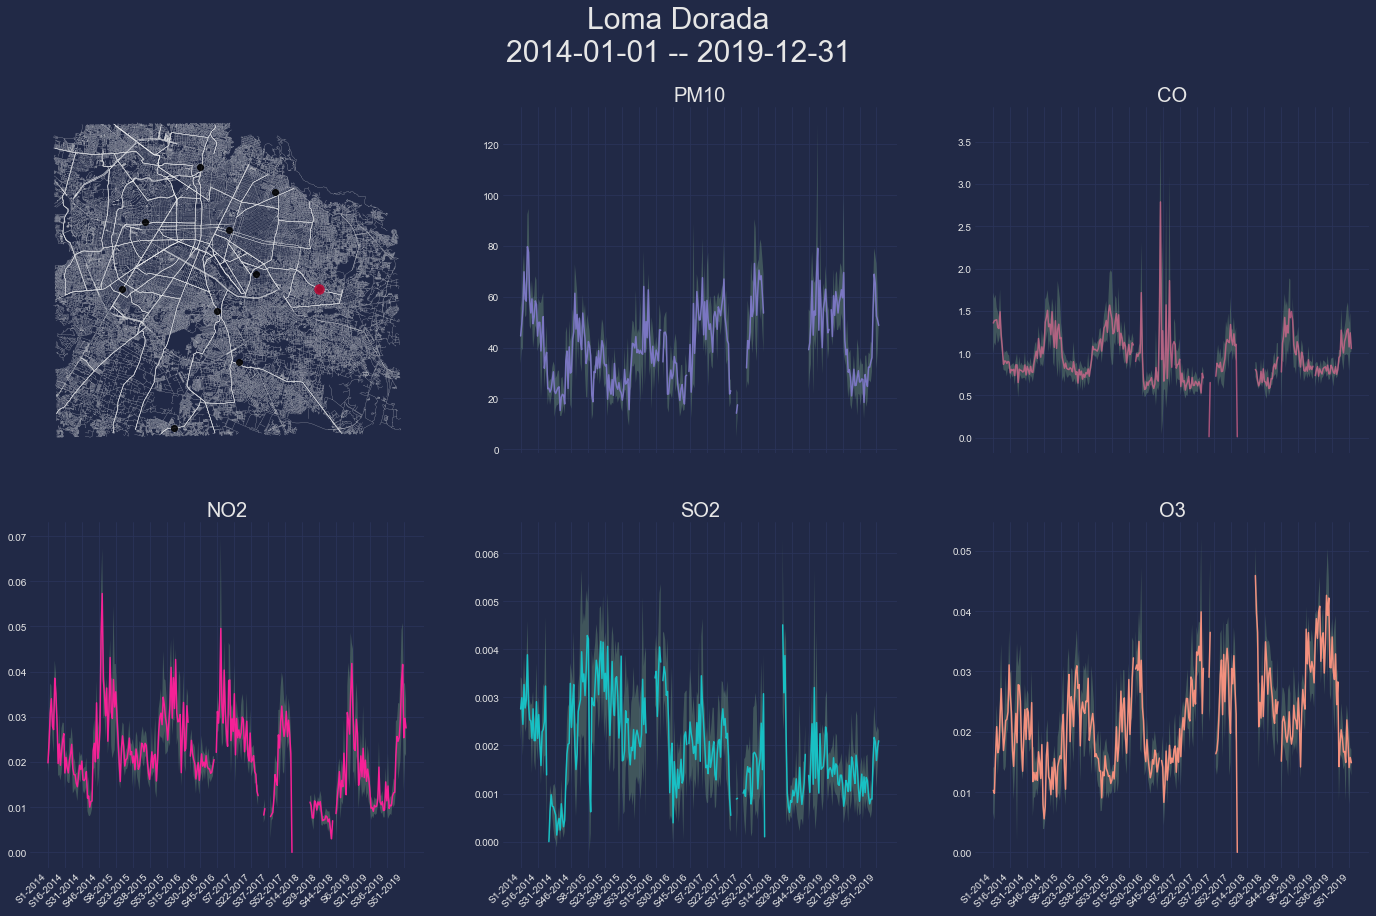

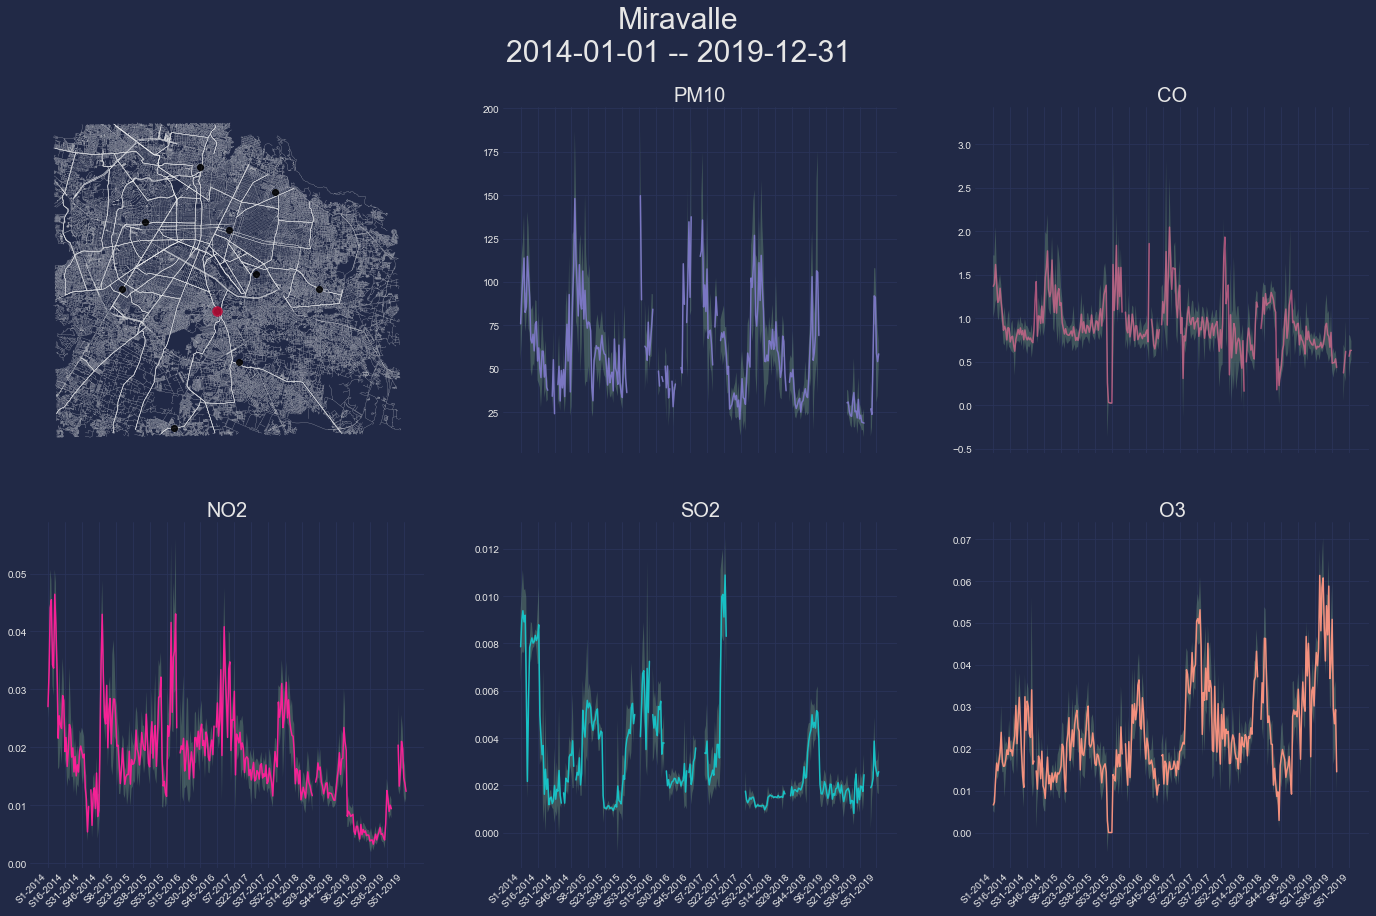

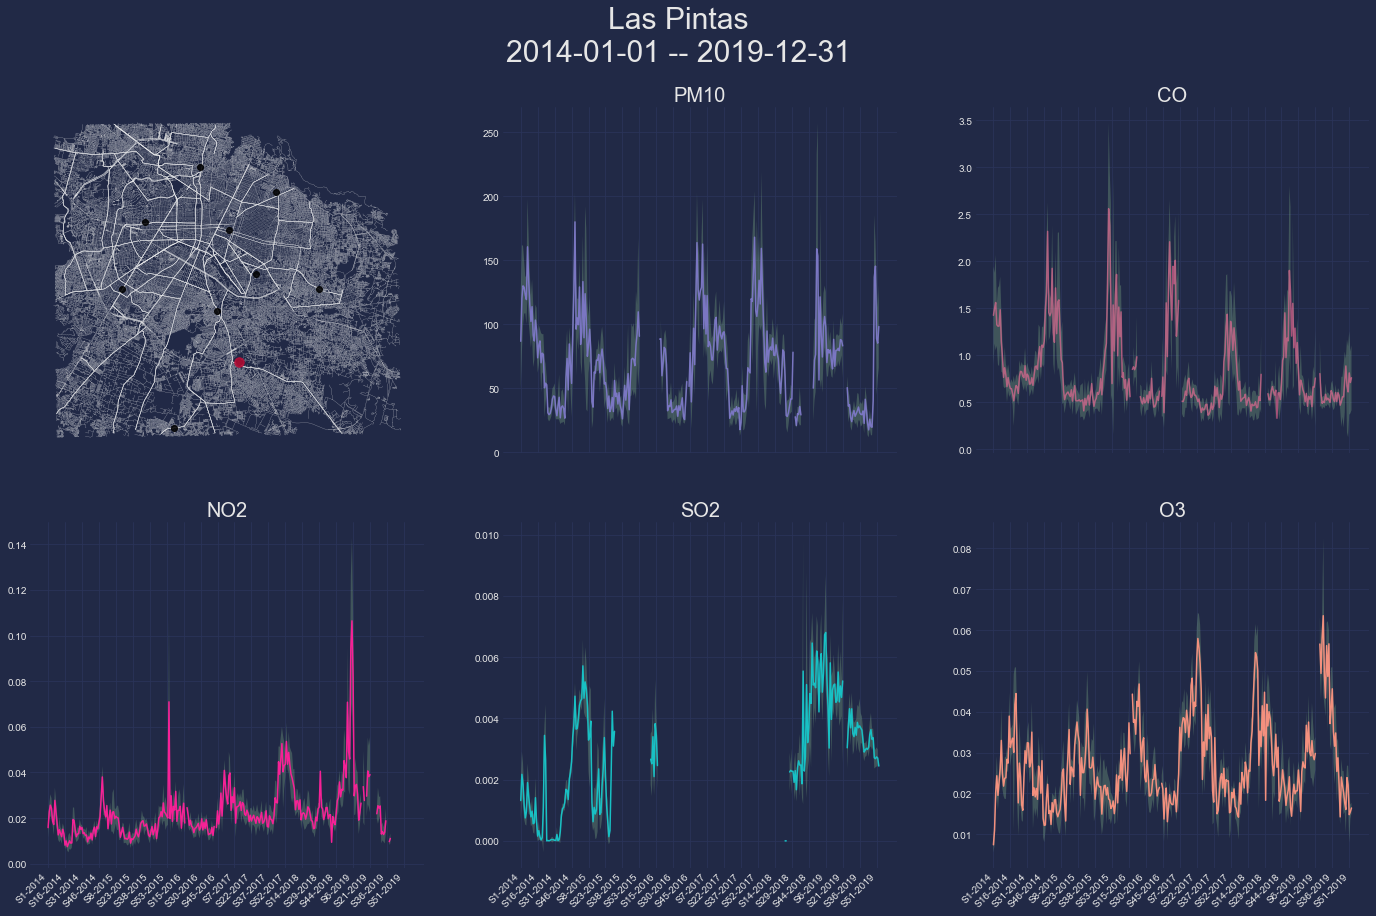

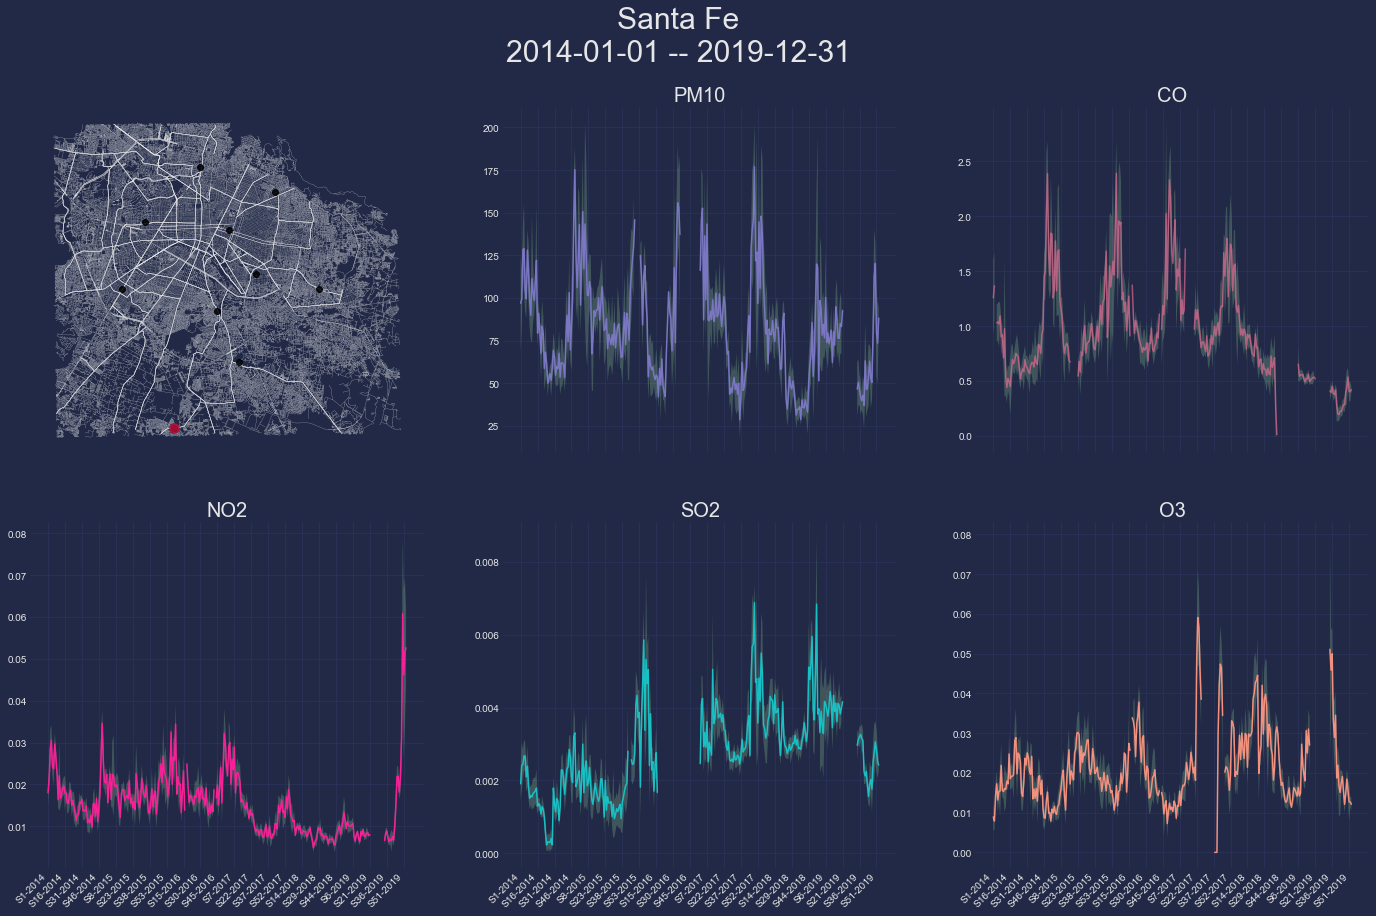

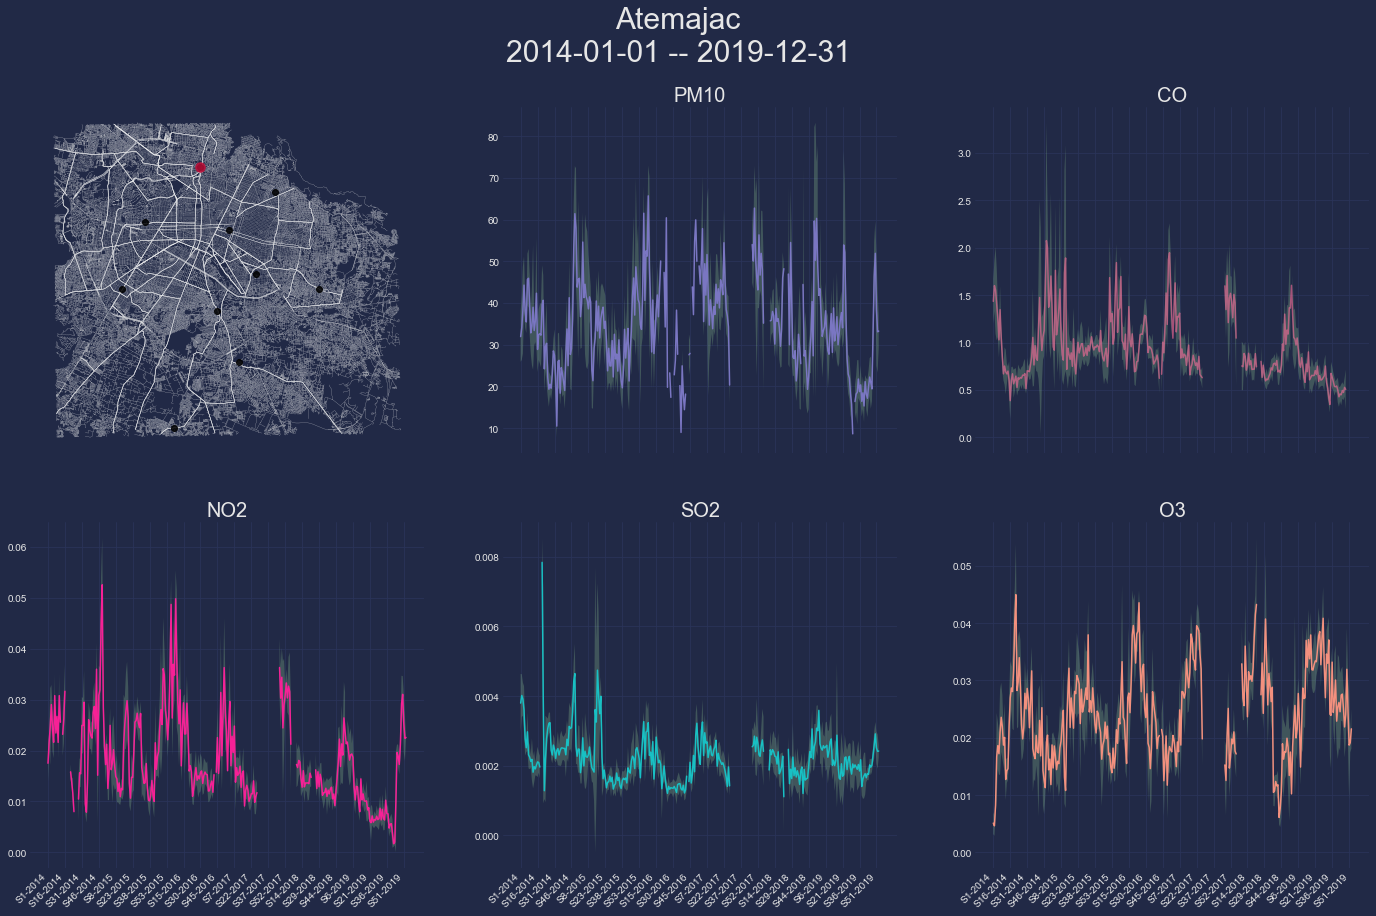

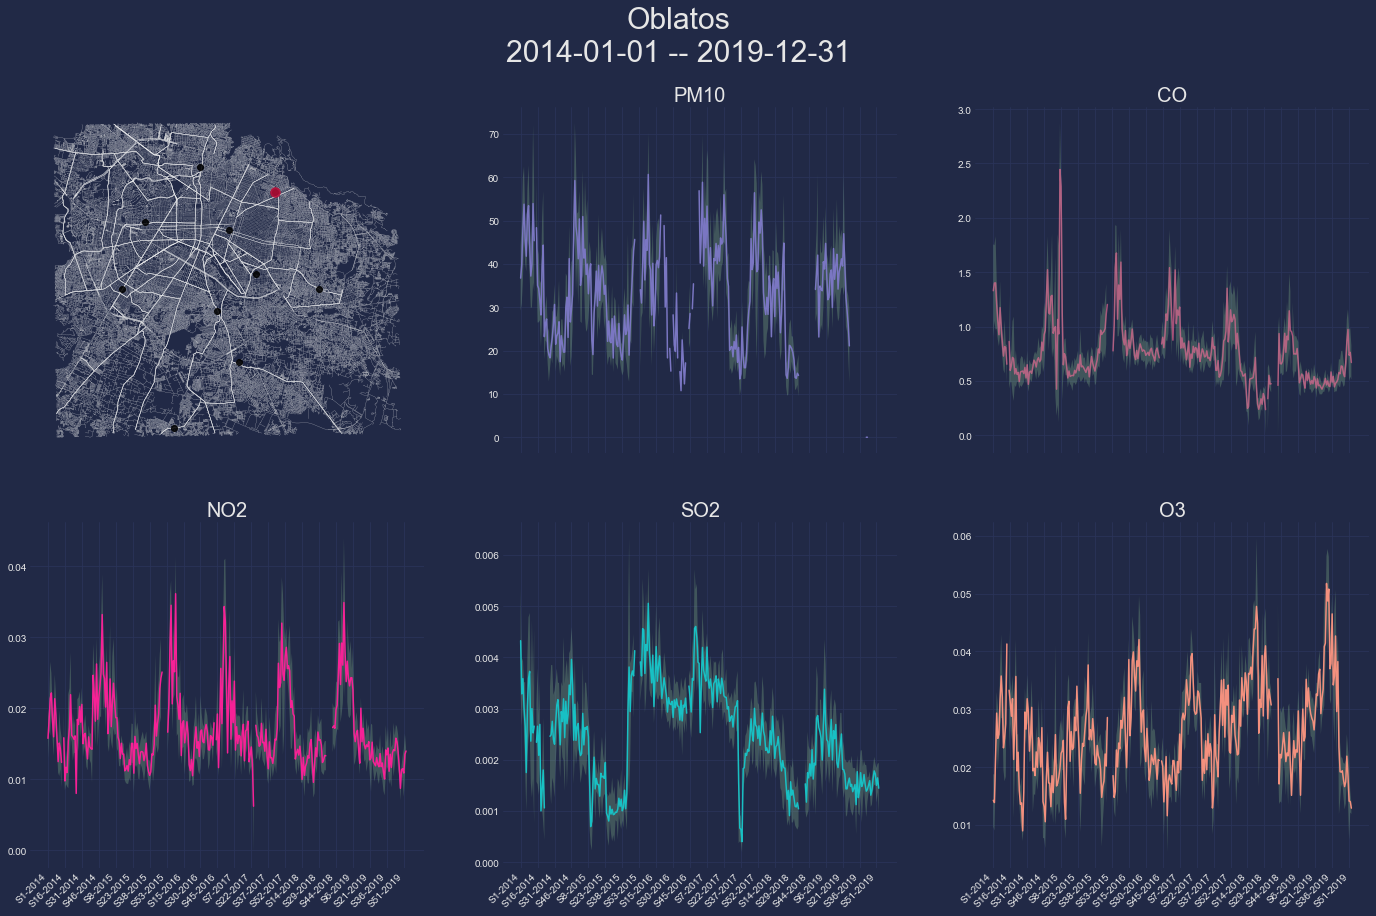

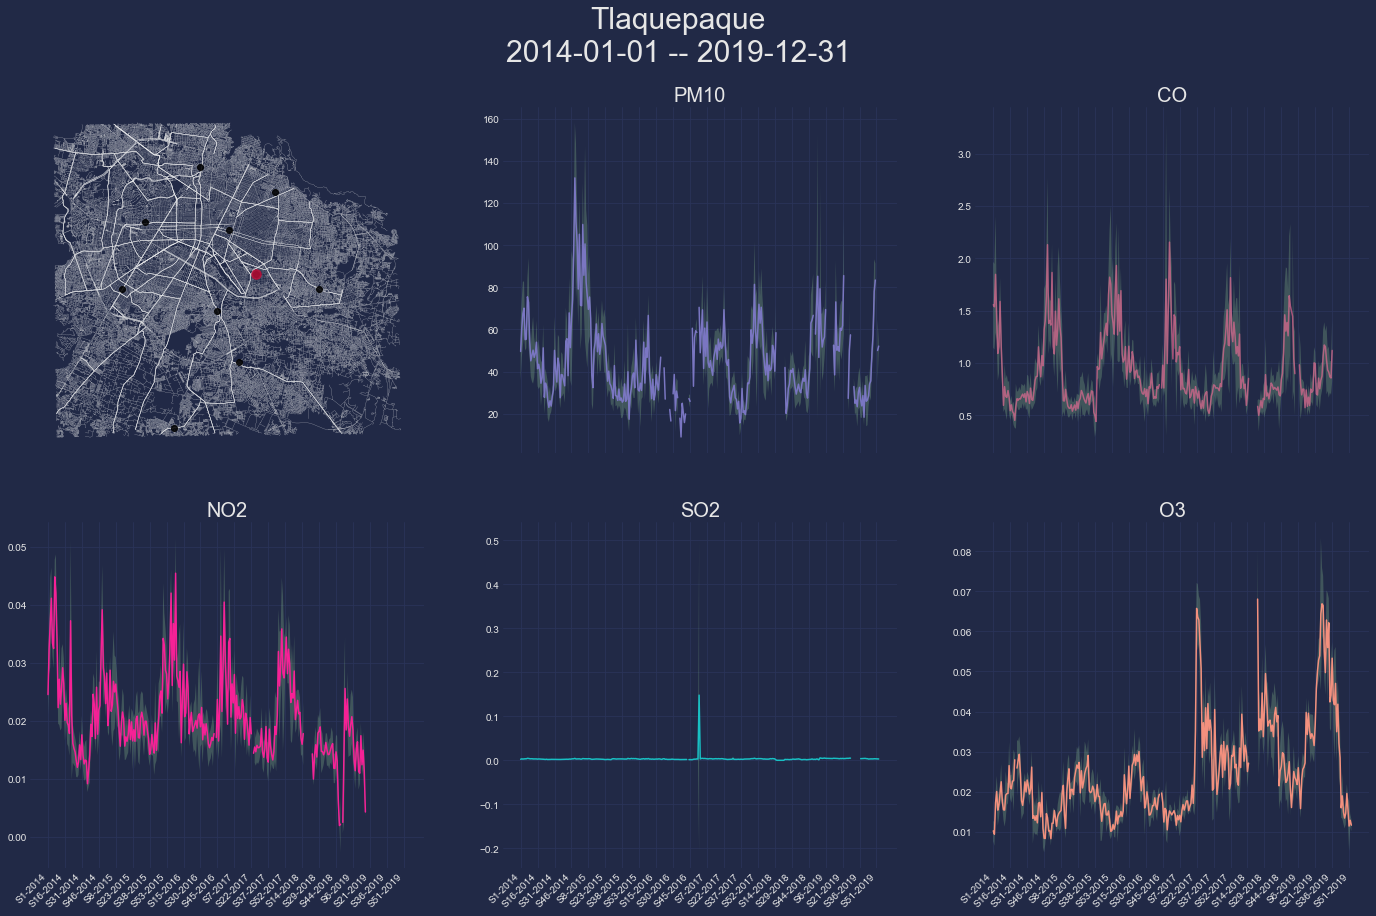

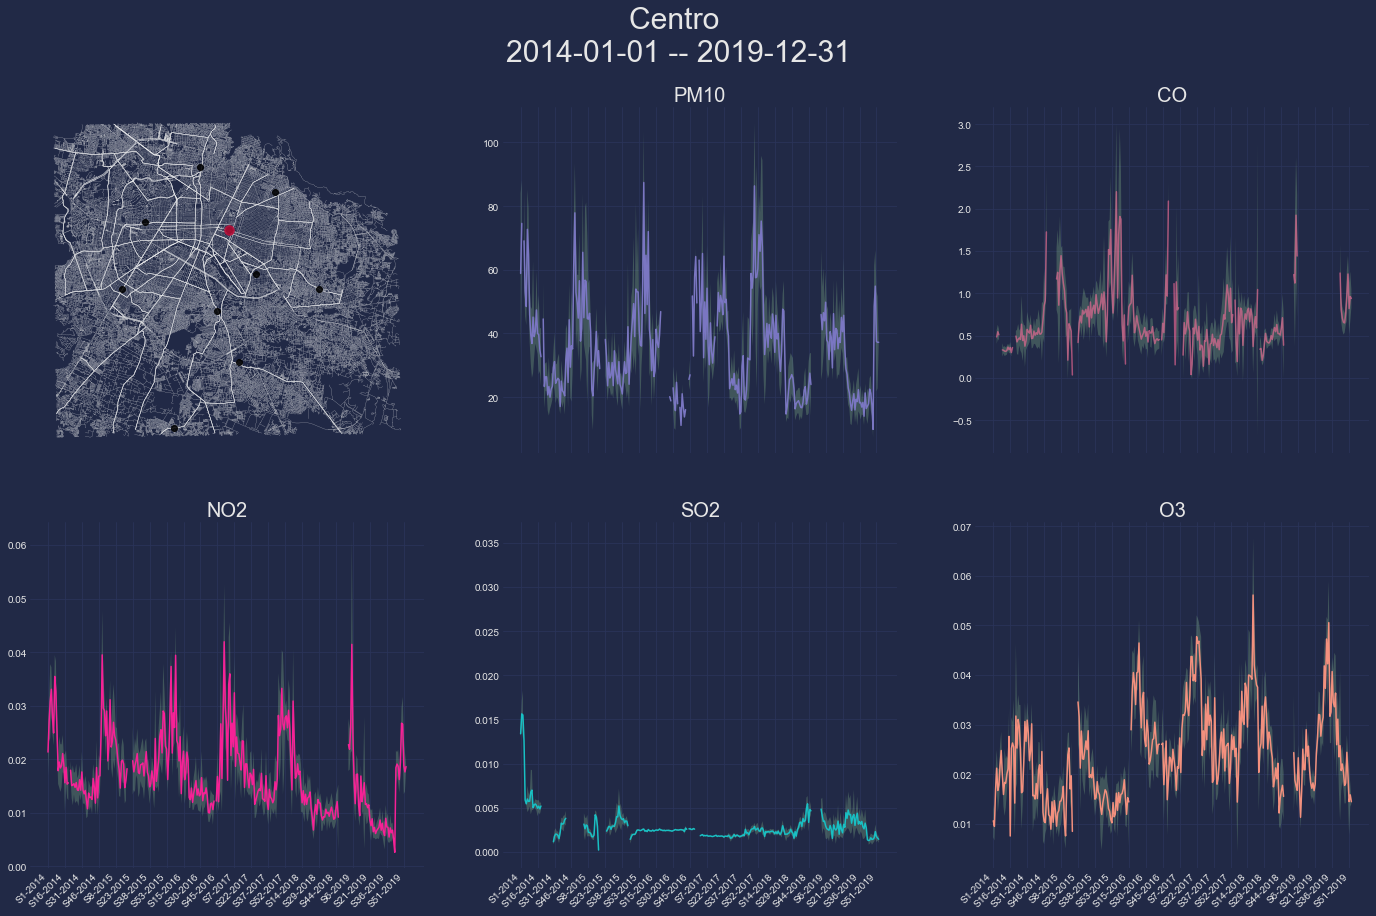

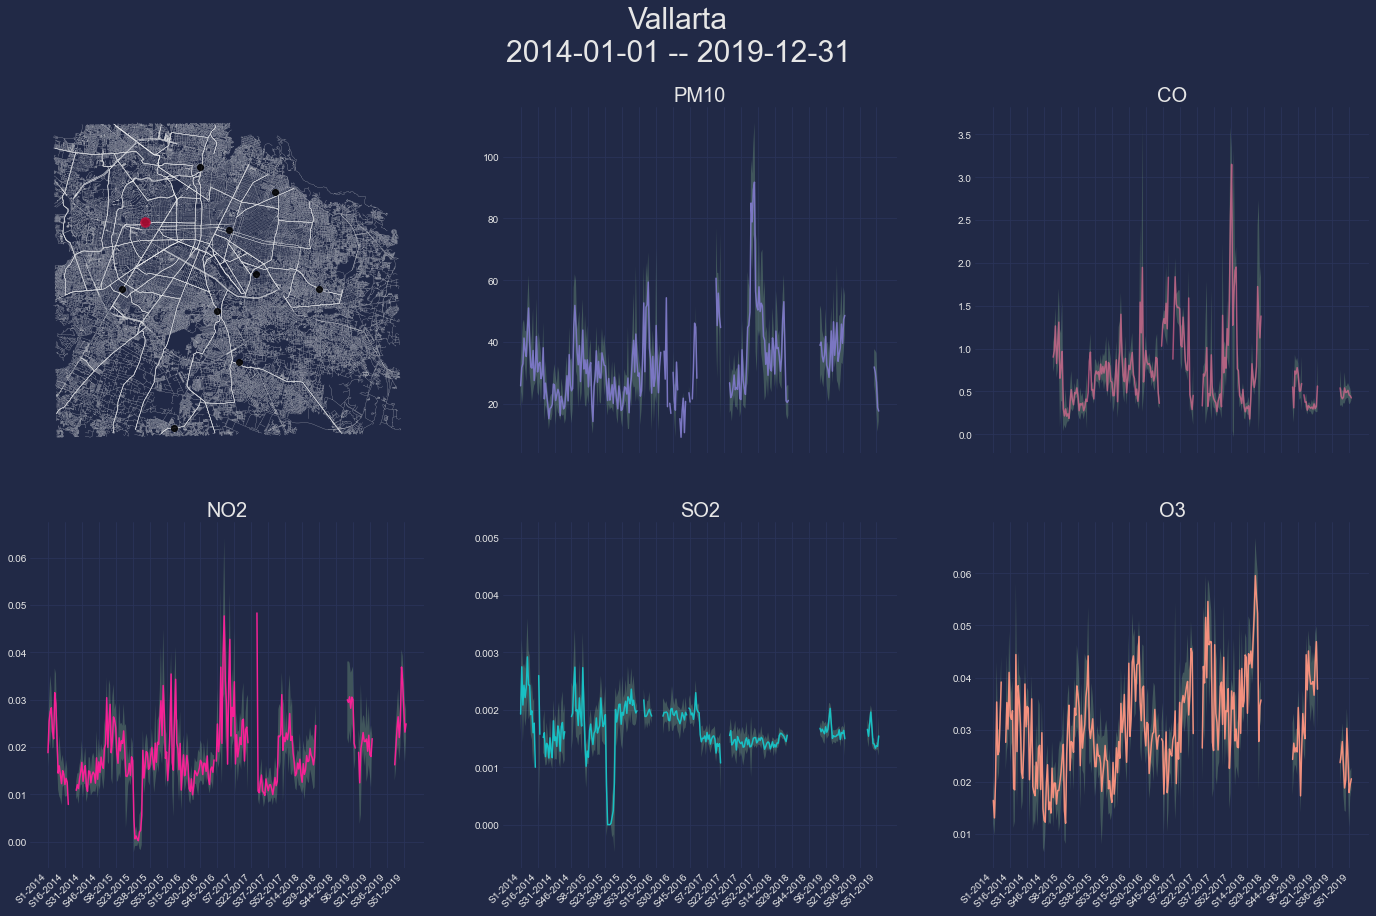

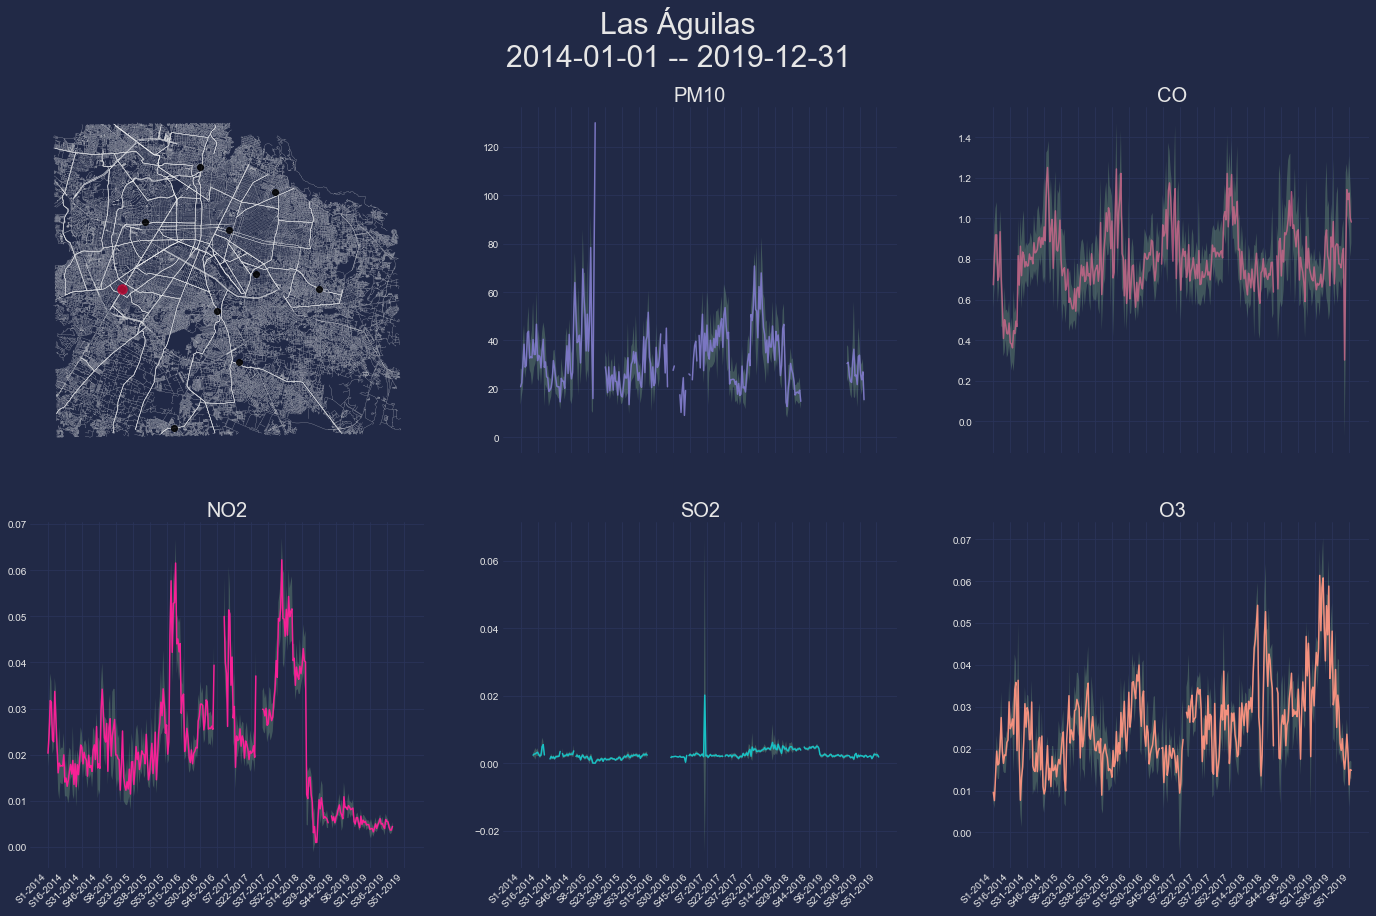

In [7]:
errors = []
for est in df_week.EST_SIMAJ.unique().tolist():
    try:
        fig, axes = plt.subplots(2,3,figsize=(24,14), sharex=True)
        for param, ax, color in zip(df_week.PARAM.unique().tolist(), axes.flatten()[1:], colors):
            df_temp = df_week[(df_week['EST_SIMAJ']==est) & (df_week['PARAM']==param)]
            ax.plot(df_temp['S_YEAR'], df_temp['CONC'], label=param, color='#'+color)

            #rellena el espacio entre desviaciones estandar
            ax.fill_between(range(len(df_temp)), 
                                   df_temp['STD']*-1+df_temp['CONC'], 
                                    df_temp['STD']*1+df_temp['CONC'], 
                                   facecolor='#9ddc9b', 
                                   alpha=0.25)
            
            ax.set_title(param,fontsize=20)
            ax.tick_params(axis='x',labelrotation=45)
           
        
        x_ticks = np.arange(0, len(df_temp['S_YEAR']),15)
        for i in range(0,3):
            plt.sca(axes[1, i])
            plt.xticks(x_ticks, horizontalalignment="right");
    
        a00 = axes[0,0]
        shax = a00.get_shared_x_axes()
        shax.remove(a00)
        edges.plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.1, zorder=-1)
        edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.5, zorder=0)
        gdf_est_simaj.plot(ax=axes[0][0], color='k', alpha=0.85, zorder=1)
        gdf_est_simaj[gdf_est_simaj['codigo']==est].plot(ax=axes[0][0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
        axes[0][0].axis('off')
        estacion = gdf_est_simaj[gdf_est_simaj['codigo']==est]['nombre'].values[0]
        fecha_1 = '2014-01-01'
        fecha_2 = '2019-12-31'
        fig.suptitle(f'{estacion}\n{fecha_1} -- {fecha_2}', fontsize=30)
        
        #plt.savefig(f'../output/figures/estsimaj/{est}_{fecha_1}_{fecha_2}.png',dpi=300)
        plt.show()
        #plt.close()
    except Exception as e:
        errors.append(est)
        pass

In [10]:
query = f"SELECT * FROM data.simaj_data_day WHERE \"FECHA\" between \'{inicio}\' and \'{fin}\'"
df = aqiGDL.df_from_query(query)
df

FECHA PARAM EST_SIMAJ      CONC        LONG        LAT
0       2015-01-01    O3       ATM  0.023380 -103.355435  20.719674
1       2015-01-01    O3       AGU  0.022375 -103.416431  20.631268
2       2015-01-01    O3       CEN  0.016962 -103.333336  20.673765
3       2015-01-01    O3       PIN  0.021518 -103.326529  20.576824
4       2015-01-01    O3       LDO  0.016673 -103.263974  20.629295
...            ...   ...       ...       ...         ...        ...
109545  2016-12-31   SO2       VAL  0.001888 -103.398551  20.680193
109546  2016-12-31   SO2       CEN       NaN -103.333336  20.673765
109547  2016-12-31   SO2       AGU  0.002450 -103.416431  20.631268
109548  2016-12-31   SO2       LDO  0.003155 -103.263974  20.629295
109549  2016-12-31   SO2       MIR       NaN -103.343333  20.614444

[109550 rows x 6 columns]

In [11]:
df.loc[(df.FECHA=='2016-10-23')&(df.PARAM=='O3')]

FECHA PARAM EST_SIMAJ  CONC        LONG        LAT
106050  2016-10-23    O3       ATM   NaN -103.355435  20.719674
106051  2016-10-23    O3       OBL   NaN -103.296617  20.700539
106052  2016-10-23    O3       PIN   NaN -103.326529  20.576824
106053  2016-10-23    O3       SFE   NaN -103.377179  20.529149
106054  2016-10-23    O3       TLA   NaN -103.312592  20.640967
106055  2016-10-23    O3       VAL   NaN -103.398551  20.680193
106056  2016-10-23    O3       CEN   NaN -103.333336  20.673765
106057  2016-10-23    O3       AGU   NaN -103.416431  20.631268
106058  2016-10-23    O3       LDO   NaN -103.263974  20.629295
106059  2016-10-23    O3       MIR   NaN -103.343333  20.614444

In [48]:
inicio = '2013/21/31'
fin = '2019/12/31'
query = f"SELECT * FROM data.simaj_data_week"
df = aqiGDL.df_from_query(query)

In [49]:
df

CONC        LONG        LAT PARAM EST_SIMAJ S_ID    S_YEAR  \
0      44.569167 -103.263974  20.629295  PM10       LDO   S1   S1-2014   
1      49.311310 -103.263974  20.629295  PM10       LDO   S2   S2-2014   
2      55.020238 -103.263974  20.629295  PM10       LDO   S3   S3-2014   
3      69.833929 -103.263974  20.629295  PM10       LDO   S4   S4-2014   
4      59.077381 -103.263974  20.629295  PM10       LDO   S5   S5-2014   
...          ...         ...        ...   ...       ...  ...       ...   
15895   0.023440 -103.416431  20.631268    O3       AGU  S49  S49-2019   
15896   0.018899 -103.416431  20.631268    O3       AGU  S50  S50-2019   
15897   0.011348 -103.416431  20.631268    O3       AGU  S51  S51-2019   
15898   0.015000 -103.416431  20.631268    O3       AGU  S52  S52-2019   
15899   0.014826 -103.416431  20.631268    O3       AGU  S53  S53-2019   

             STD  
0      11.032320  
1       9.348618  
2      16.193749  
3       7.184874  
4       7.158429  
...          ...  
15895   0.003593  
15896   0.003892  
15897   0.005365  
15898   0.002127  
15899   0.002053  

[15900 rows x 8 columns]